In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Funtion and Constants Definition

In [120]:
COLS = ["type", "time (ms)"]

DATA_NEW_HILS_PREFIX = "./data/new-hils/"
DATA_NEW_HILS_1_PREFIX = f"{DATA_NEW_HILS_PREFIX}/2023-07-22_001/"
DATA_NEW_HILS_2_PREFIX = f"{DATA_NEW_HILS_PREFIX}/2023-07-22_002/"

DATA_OLD_HILS_PREFIX = "./data/old-hils/"

DATA_RKB_PREFIX = "./data/rkb/"

In [114]:
def remove_outlier_using_turkey_method(ser: pd.Series):
    q1 = ser.quantile(0.25)
    q3 = ser.quantile(0.75)
    iqr = q3 - q1
    print(q1, q3, iqr)
    lb = q1 - 1.5 * iqr
    ub = q3 + 1.5 * iqr
    return ser[(ser >= lb) & (ser <= ub)]

def get_real_rtt(df_raw_rtt: pd.DataFrame, df_process_latency: pd.DataFrame):
    time = COLS[1]
    ser = pd.Series()
    ser = df_raw_rtt[time] - df_process_latency[time]
    return ser

# ZeroMQ RTT and Latency

This section calculates the RTT (round trip time) and latency of ZeroMQ. Latency is approximated with the formula:
$$
\text{latency} \approx \frac{\text{RTT}}{2}
$$

The round trip time is
$$
\text{RTT} = \text{send a sensor data time} - \text{process time} + \text{send control time} 
$$
For testing, the sensor that will be used is camera. This is because only 2 sensors are used: GNSS and camera and camera has the largest data size between the two. To get the worst case scenario, we are choosing the sensor with the biggest data.

Also a note, because the camera data is large it is split into chunks and each chunk is sent one by one as a multipart message. But, we will calculate the RTT from the first chunk. The reason for choosing the first chunk so we get the latency of sending the whole camera data. Fortunately, this shouldn't really affect the calculation of the whole RTT as seen in [Camera Receive Time](#camera-receive-time) section.

In [122]:
raw_rtt_1 = pd.read_csv(DATA_NEW_HILS_1_PREFIX + "log_delta_time_raw_rtt.csv", names=COLS, header=None)
raw_rtt_2 = pd.read_csv(DATA_NEW_HILS_2_PREFIX + "log_delta_time_raw_rtt.csv", names=COLS, header=None)
process_latency_1 = pd.read_csv(DATA_NEW_HILS_1_PREFIX + "log_delta_time_process_latency.csv", names=COLS, header=None)
process_latency_2 = pd.read_csv(DATA_NEW_HILS_2_PREFIX + "log_delta_time_process_latency.csv", names=COLS, header=None)

In [123]:
raw_rtt_1.tail()

,type,time (ms)
3121,ZEROMQ_RAW_RTT_3121,62
3122,ZEROMQ_RAW_RTT_3122,63
3123,ZEROMQ_RAW_RTT_3123,60
3124,ZEROMQ_RAW_RTT_3124,63
3125,ZEROMQ_RAW_RTT_3125,66


In [124]:
real_rtt_1 = get_real_rtt(raw_rtt_1, process_latency_1)
real_rtt_1 = remove_outlier_using_turkey_method(real_rtt_1)

real_rtt_2 = get_real_rtt(raw_rtt_2, process_latency_2)
real_rtt_2 = remove_outlier_using_turkey_method(real_rtt_2)

real_rtt = np.append(real_rtt_1.to_numpy(), real_rtt_2.to_numpy())
real_rtt = pd.Series(real_rtt)
real_rtt.describe()

11.0 25.0 14.0
21.0 25.0 4.0


count    16891.000000
mean        21.979930
std          4.497563
min          9.000000
25%         20.000000
50%         22.000000
75%         25.000000
max         39.000000
dtype: float64

In [125]:
latencies = real_rtt / 2
latencies.describe()

count    16891.000000
mean        10.989965
std          2.248782
min          4.500000
25%         10.000000
50%         11.000000
75%         12.500000
max         19.500000
dtype: float64

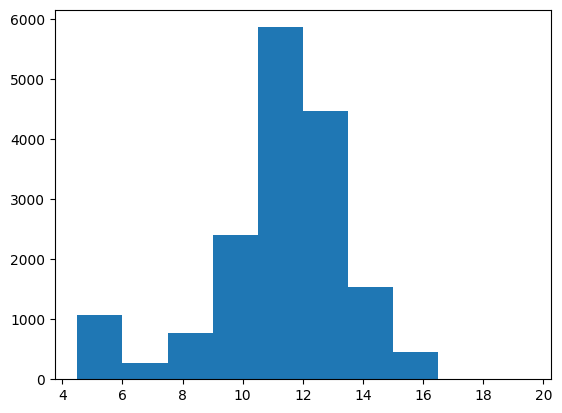

In [185]:
plt.hist(latencies)
plt.show()

# Camera Receive Time

This section shows the difference in time received for each chunk of camera data.

In [236]:
rkb_log_time = pd.read_csv(DATA_RKB_PREFIX + "log_time.csv", names=COLS, header=None)
valid_types = [f"ZEROMQ_ZMQ_ENDPOINT_CAMERA_RECEIVE_{i}" for i in range(100)]

In [237]:
receive_time[COLS[1]] = np.floor(rkb_log_time[COLS[1]] / 1_000_000).astype(np.uint64)
receive_time = receive_time[receive_time[COLS[0]].isin(valid_types)]

In [238]:
receive_time.head(11)

,type,time (ms)
1,ZEROMQ_ZMQ_ENDPOINT_CAMERA_RECEIVE_0,1687430302976
2,ZEROMQ_ZMQ_ENDPOINT_CAMERA_RECEIVE_1,1687430302976
3,ZEROMQ_ZMQ_ENDPOINT_CAMERA_RECEIVE_2,1687430302976
4,ZEROMQ_ZMQ_ENDPOINT_CAMERA_RECEIVE_3,1687430302977
5,ZEROMQ_ZMQ_ENDPOINT_CAMERA_RECEIVE_4,1687430302977
6,ZEROMQ_ZMQ_ENDPOINT_CAMERA_RECEIVE_5,1687430302977
7,ZEROMQ_ZMQ_ENDPOINT_CAMERA_RECEIVE_6,1687430302977
8,ZEROMQ_ZMQ_ENDPOINT_CAMERA_RECEIVE_7,1687430302977
9,ZEROMQ_ZMQ_ENDPOINT_CAMERA_RECEIVE_8,1687430302977
10,ZEROMQ_ZMQ_ENDPOINT_CAMERA_RECEIVE_9,1687430302977


In [286]:
receive_time_chunks = np.array_split(receive_time, receive_time.shape[0] / 11)

In [290]:
for chunk in receive_time_chunks:
    chunk[COLS[0]] = "diff to previous"
    chunk[COLS[1]] = chunk[COLS[1]].diff()
    chunk.dropna(inplace=True)
receive_time_chunks[0]

,type,time (ms)
3,diff to previous,0.0
4,diff to previous,1.0
5,diff to previous,-1.0
6,diff to previous,0.0
7,diff to previous,0.0
8,diff to previous,0.0
9,diff to previous,0.0
10,diff to previous,0.0
11,diff to previous,0.0


In [291]:
receive_time_diff = pd.concat(receive_time_chunks)
receive_time_diff.describe()

,time (ms)
count,166482.000000
mean,-0.002301
std,0.201360
min,-1.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


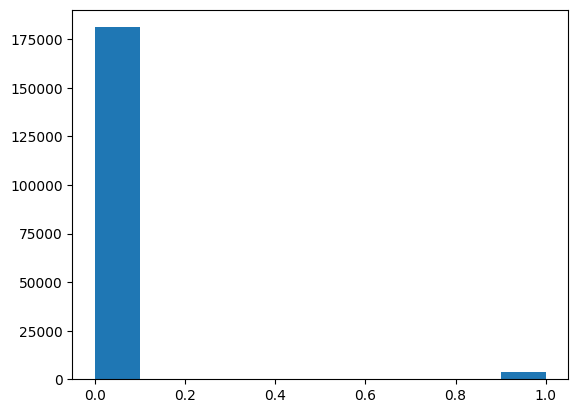

In [289]:
plt.hist(receive_time_diff[COLS[1]])
plt.show()

As can be seen, the difference in latency caused by chunking the camera frame is negligible. As the difference of time between each chunk is either 0 or 1, with most of the data being 0.

# Old HILS "Scientific" Latency

This section calculates the latency of the old HILS connector implementation. The details of the implementation can be seen in the paper or the book. This part only calculates latency during the process of sending data from a "sender" (produces sensor data) to a "receiver" (consumer of sensor data). The latency is only scientific and not real because the HTTP latency is not accounted for.